In [1]:
import scanpy as sc

Nadav did a cool thing and stitched together a human limb of three separate Visium slides. He did all the image lifting:
- put together the three images into one
- the size factors were exactly the same (likely as the result of the same exact zoom being used when taking the slide pictures), so there was no need to mess with the source images on that axis
- once the images were put together, he corrected the underlying spot coordinates so they're all compatible

The files exist in three separate Visium mapping folders, with an extra `spatial_0` folder with the new stuff. And now we need to join them somehow!

We can't exactly just `sc.read_visium()` the thing as that specifically requires `.h5` formatted matrices. However, we can emulate the final outcome of `sc.read_visium()` by importing the three count matrices separately, merging them, and then adding the stitched together limb into the necessary spatial slots of the object. Start with the count matrices!

In [2]:
bdata1 = sc.read_10x_h5("/nfs/team205/ny1/limb/WSSS_THYst9383360/outs/raw_feature_bc_matrix.h5")
bdata1.var_names_make_unique()
bdata2 = sc.read_10x_h5("/nfs/team205/ny1/limb/WSSS_THYst9383361/outs/raw_feature_bc_matrix.h5")
bdata2.var_names_make_unique()
bdata3 = sc.read_10x_h5("/nfs/team205/ny1/limb/WSSS_THYst9383362/outs/raw_feature_bc_matrix.h5")
bdata3.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Three samples coming together means three sets of barcodes that need to be flagged with sample IDs. Also add a piece of sample metadata for easier diagnostics later.

In [3]:
bdata1.obs_names = ["WSSS_THYst9383360_"+i for i in bdata1.obs_names]
bdata1.obs["sample"] = "WSSS_THYst9383360"
bdata2.obs_names = ["WSSS_THYst9383361_"+i for i in bdata2.obs_names]
bdata2.obs["sample"] = "WSSS_THYst9383361"
bdata3.obs_names = ["WSSS_THYst9383362_"+i for i in bdata3.obs_names]
bdata3.obs["sample"] = "WSSS_THYst9383362"

Stick the three count matrices together.

In [4]:
adata = bdata1.concatenate(bdata2, bdata3, index_unique=None)

Start preparing the spatial stuff in the object, mirroring `sc.read_spatial()` source code in terms of import and storage and whatnot.

Create the base slots for the thing. The chosen library ID doesn't really matter.

In [5]:
adata.uns["spatial"] = dict()
library_id = "joint"
adata.uns["spatial"][library_id] = dict()

The image is imported like so. Use the stitched together one Nadav provided.

In [6]:
from matplotlib.image import imread

adata.uns["spatial"][library_id]['images'] = dict()
adata.uns["spatial"][library_id]['images']["hires"] = imread("/nfs/team205/ny1/limb/tissue_hires_image.png")

Import the scale factor JSON. This is technically marginally different syntax than the scanpy code but it gets the job done.

As a reminder, this is consistent across all three images, so use whichever one and it's ok.

In [7]:
import json

with open("/nfs/team205/ny1/limb/WSSS_THYst9383360/outs/spatial_0/scalefactors_json.json", "r") as fid:
    adata.uns["spatial"][library_id]['scalefactors'] = json.load(fid)

And now for the fun part - the spatial coordinates, which are present in three separate files. Import the three separate files.

In [8]:
import pandas as pd

p1 = pd.read_csv("/nfs/team205/ny1/limb/WSSS_THYst9383360/outs/spatial_0/tissue_positions_list.csv", header=None)
p2 = pd.read_csv("/nfs/team205/ny1/limb/WSSS_THYst9383361/outs/spatial_0/tissue_positions_list.csv", header=None)
p3 = pd.read_csv("/nfs/team205/ny1/limb/WSSS_THYst9383362/outs/spatial_0/tissue_positions_list.csv", header=None)

Name the columns appropriately and set the index. In the process also add the sample ID as a prefix to the barcodes so it matches the object.

In [9]:
p1.columns = [
    'barcode',
    'in_tissue',
    'array_row',
    'array_col',
    'pxl_col_in_fullres',
    'pxl_row_in_fullres',
]
p1['barcode'] = ["WSSS_THYst9383360_"+i for i in p1['barcode']]
p1.index = p1['barcode']

p2.columns = [
    'barcode',
    'in_tissue',
    'array_row',
    'array_col',
    'pxl_col_in_fullres',
    'pxl_row_in_fullres',
]
p2['barcode'] = ["WSSS_THYst9383361_"+i for i in p2['barcode']]
p2.index = p2['barcode']

p3.columns = [
    'barcode',
    'in_tissue',
    'array_row',
    'array_col',
    'pxl_col_in_fullres',
    'pxl_row_in_fullres',
]
p3['barcode'] = ["WSSS_THYst9383362_"+i for i in p3['barcode']]
p3.index = p3['barcode']

Concatenate the three individual files into one now that all the prep is done.

In [10]:
positions = pd.concat([p1, p2, p3])

Absorb into the object.

In [11]:
adata.obs = adata.obs.join(positions, how="left")

adata.obsm['spatial'] = adata.obs[
    ['pxl_row_in_fullres', 'pxl_col_in_fullres']
].to_numpy()
adata.obs.drop(
    columns=['barcode', 'pxl_row_in_fullres', 'pxl_col_in_fullres'],
    inplace=True,
)

Plot the sample...

... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


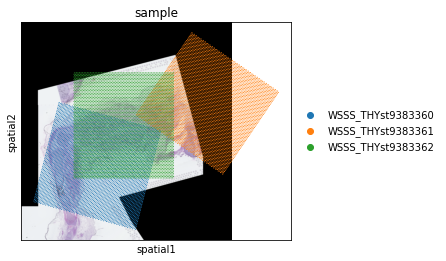

In [12]:
sc.pl.spatial(adata, color="sample")

Huh, that isn't right. Nadav expressed the possibility that the coordinates may have been flipped, so try that.

In [13]:
spatial = adata.obsm['spatial'].copy()
adata.obsm['spatial'][:,0] = spatial[:,1]
adata.obsm['spatial'][:,1] = spatial[:,0]

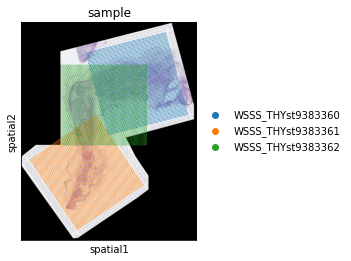

In [14]:
sc.pl.spatial(adata, color="sample")

Hey that's better! Add another diagnostic plot with `in_tissue`.

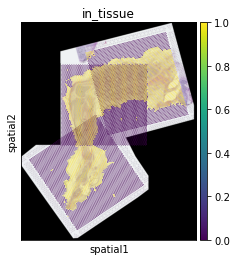

In [15]:
sc.pl.spatial(adata, color="in_tissue")

This will do just fine for subsequent analysis.

In [16]:
adata.write('joint.h5ad')